CRON

In [24]:
import numpy as np 
import pandas as pd 
import datetime as dt 
# import pylab as pl 
# import os 
# from wmf import wmf 
# from multiprocessing import Pool
# import matplotlib
# import MySQLdb

# import json
from cpr import cpr
import pickle
import alarmas as al
import funciones_sora as fs
import glob

#Ignorar avisos pendejos
import warnings
warnings.filterwarnings('ignore')

In [3]:
date = dt.datetime.now()
dateText = dt.datetime.now().strftime('%Y-%m-%d-%H:%M')

print '\n'
print '###################################### Fecha de Ejecucion: '+dateText+' #############################\n'

#Lectura de ruta de configuracion.
ruta_config= '/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/configfile_web.md'
listconfig = al.get_rutesList(ruta_config)
#Lectura de rutas
ruta_estadistico=al.get_ruta(listconfig,'ruta_estadistico')
ruta_pluvioforecast=al.get_ruta(listconfig,'ruta_pluvioforecast')
rutaN=al.get_ruta(listconfig,'rutaN_infoeventos')
rutaP=al.get_ruta(listconfig,'rutaP_infoeventos')
rutafigsN=al.get_ruta(listconfig,'rutaFigsNbandas')
rutafigsP=al.get_ruta(listconfig,'rutaFigsPbandas')
#Lectura del assignfile
dfconfig=pd.read_json(al.get_ruta(listconfig,'ruta_JSONinfosirenas'))

#--------------------------------
#Lectura de resultados de modelos 
#--------------------------------

#Estadistico
# se lee la info del pronostico Estadistico 30m
f=open(ruta_estadistico)
n_pronos1=pickle.load(f)
f.close()
n_pronos=pd.DataFrame(n_pronos1)
columns=['codigo','n30p25','n30p50','n30p75','Ttop25','Ttop50','Ttop75']
n_pronos.columns=columns
n_pronos['codigo']=map(int,n_pronos['codigo'])
n_pronos.index=n_pronos['codigo']
n_pronos=n_pronos.drop('codigo',axis=1)
n_pronos=n_pronos.T

#Pluvio Forecast
f = open(ruta_pluvioforecast+'_cast_normal.rain','r')
cast_normal = pickle.load(f)
f.close()

#--------------------
#Ejecucion de figuras
#--------------------

#tick labels for evolution figures
timedeltaEv=5 #min
# label time
hours=np.arange(-3,4)
rng1=[]
for i in range(hours.size):
    if hours[i]<0:
        rng1.append('-0'+str(np.abs(hours[i]))+':00')
    else:
        rng1.append('0'+str(np.abs(hours[i]))+':00')
rng1=np.array(rng1)

#NIVEL
#estaciones.
ests=np.unique(np.hstack(dfconfig['EstNivel']))
ests=ests[np.where(ests)[0]]
est_outfig=[246,272,239,173,186,251,259,283,155]
#todas
for est in np.unique(ests):
    if int(est) in est_outfig:
        pass
    else:
        al.plotN_vs_History(int(est),ruta_consultaN3h,dfconfig,n_pronos,rutaN,rutafigsN,rng1,timedeltaEv)
        
# #PLUVIO

# est_noH=[267,281,43 ,261,253]
# #se leen las est a plotear
# paths_p=glob.glob(rutaP+'bandas*')
# ests_p=[i.split('/')[-1].split('_')[-1][:-4] for i in paths_p]
# #fechas para consultar pluvio.
# start=(dt.datetime.now()-pd.Timedelta('3 days')).strftime('%Y-%m-%d-%H:%M')
# end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
# # for para todas
# for est_p in np.sort(ests_p):
#     if int(est_p) in est_noH:
#         pass
#     else:
#         al.plotP_vs_History(est_p,start,end,rutaP,rutafigsP,cast_normal,rng1,timedeltaEv)



###################################### Fecha de Ejecucion: 2018-05-25-14:23 #############################



In [36]:
%matplotlib inline  

# CRON MARIO

In [37]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#  Copyright 2018 MCANO <mario.cano@siata.gov.co>
import cprv1.cprv1 as cpr
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import os
import numpy as np
import multiprocessing
import time
import wmf.wmf as wmf
#paquetes sora
import pickle
import alarmas as al
import glob

def logger(orig_func):
    '''logging decorator, alters function passed as argument and creates
    log file. (contains function time execution)
    Parameters
    ----------
    orig_func : function to pass into decorator
    Returns
    -------
    log file
    '''
    import logging
    from functools import wraps
    import time
    logging.basicConfig(filename = 'reporte_nivel.log',level=logging.INFO)
    @wraps(orig_func)
    def wrapper(*args,**kwargs):
        start = time.time()
        f = orig_func(*args,**kwargs)
        date = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
        took = time.time()-start
        log = '%s:%s:%.1f sec'%(date,orig_func.__name__,took)
        print log
        logging.info(log)
        return f
    return wrapper

@logger
def data_base_query():
    return self.level_all()

def convert_to_risk(df):
    df = self.risk_df(df)
    return df[df.columns.dropna()]

def risk_report(df):
    return self.make_risk_report_current(df)

def plot_level(codigo):
    try:
        resolution='3h' # will be argument later on
        path = '/media/nicolas/Home/Jupyter/MarioLoco'
        if resolution == '3h':
            folder = 'tres_horas'
        obj = cpr.Nivel(codigo = codigo,user='sample_user',passwd='s@mple_p@ss',SimuBasin=False)
        levantamiento = pd.read_csv('%s/ultimos_levantamientos/%s.csv'%(path,codigo),index_col=0)
        filepath = '%s/%s.png'%(path+'/real_time/'+folder,obj.info.slug)
        obj.plot_operacional(df[codigo]/100.0,levantamiento,resolution,filepath=filepath)
        r = os.system('scp %s mcano@siata.gov.co:/var/www/mario/realTime/%s'%(filepath,folder))
    except:
        print 'error in plot %s'%codigo
@logger
def processs_multiple_plots():
    from multiprocessing import Pool
    if __name__ == '__main__':
        p = Pool(10)
        p.map(plot_level, list(df.columns))
        p.close()
        p.join()

@logger
def process_multiple_plots_looping():
    for codigo in df.columns:
        plot_level(codigo)   

        
@logger        
def convert_series_to_risk(level):
    '''level: pandas Series, index = codigos de estaciones'''
    risk = level.copy()
    colors = ['green','gold','orange','red','red','black']
    for codigo in level.index:
        try:
            risks = cpr.Nivel(codigo = codigo,user='sample_user',passwd='s@mple_p@ss').risk_levels
            risk[codigo] = colors[int(self.convert_level_to_risk(level[codigo],risks))]
        except:
            risk[codigo] = 'black'
    return risk

@logger
def reporte_lluvia():
    try:
        self = cpr.Nivel(codigo=260,user='sample_user',passwd = 's@mple_p@ss',SimuBasin=True)
        end = datetime.datetime.now()
        start = end - datetime.timedelta(hours=3)
        posterior = end + datetime.timedelta(minutes=10)
        rain = self.radar_rain(start,posterior)
        rain_vect = self.radar_rain_vect(start,posterior)
        codigos = self.infost.index
        df = pd.DataFrame(index = rain_vect.index,columns=codigos)
        for codigo in codigos:
            mask_path = '/media/nicolas/maso/Mario/mask/mask_%s.tif'%(codigo)
            try:
                mask_map = wmf.read_map_raster(mask_path)
                mask_vect = self.Transform_Map2Basin(mask_map[0],mask_map[1])
            except AttributeError:
                print 'mask:%s'%codigo
                mask_vect = None
            if mask_vect is not None:
                mean = []
                for date in rain_vect.index:
                    try:
                        mean.append(np.sum(mask_vect*rain_vect.loc[date])/np.sum(mask_vect))
                    except:
                        print 'mean:%s'%codigo
                if len(mean)>0:
                    df[codigo] = mean
        df_posterior = df.loc[end:]
        plt.rc('font', **{'size'   :16})
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=1.1)
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        suma = (df/1000.).sum().sort_values(ascending=False)
        suma = suma[suma>0.0]
        orden = np.array(suma.index,int)
        suma.index = self.infost.loc[suma.index,'nombre']
        risk = convert_series_to_risk(self.level_all(hours=1).iloc[-3:].max())
        dfb = pd.DataFrame(index=suma.index,columns=['rain','color'])
        dfb['rain'] = suma.values
        dfb['color'] = risk.loc[orden].values
        dfb.plot.bar(y='rain', color=[dfb['color']],ax=ax1)
        #suma.plot(kind='bar',color = list(),ax=ax1)
        title = 'start: %s, end: %s'%(start.strftime('%Y-%m-%d %H:%M'),end.strftime('%Y-%m-%d %H:%M'))
        filepath = '/media/nicolas/Home/Jupyter/MarioLoco/reportes/lluvia_en_cuencas.png'
        ax1.set_title(title)
        ax1.set_ylabel('lluvia acumulada\n promedio en la cuenca [mm]')
        suma = (df_posterior/1000.).sum().loc[orden]
        suma.index = self.infost.loc[suma.index,'nombre']
        dfb = pd.DataFrame(index=suma.index,columns=['rain','color'])
        dfb['rain'] = suma.values
        dfb['color'] = risk.loc[orden].values
        dfb.plot.bar(y='rain', color=[dfb['color']],ax=ax2)
        #suma.plot(kind='bar',ax=ax2)
        filepath = '/media/nicolas/Home/Jupyter/MarioLoco/reportes/lluvia_en_cuencas.png'
        ax2.set_title(u'lluvia acumulada en la próxima media hora')
        ax2.set_ylabel('lluvia acumulada\n promedio en la cuenca [mm]')
        ax1.set_ylim(0,30)
        ax2.set_ylim(0,30)
        plt.savefig(filepath,bbox_inches='tight')
        os.system('scp %s mcano@siata.gov.co:/var/www/mario/realTime/reporte_lluvia_cuenca.png'%filepath)
    except:
        pass

@logger
def plots_vs_History():
    #Lectura de ruta de configuracion.
    ruta_config= '/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/configfile_web.md'
    listconfig = al.get_rutesList(ruta_config)
    #Lectura de rutas
    ruta_consultaN3h=al.get_ruta(listconfig,'ruta_consultaN3h')
    # ruta_estadistico=al.get_ruta(listconfig,'ruta_estadistico')
    # ruta_pluvioforecast=al.get_ruta(listconfig,'ruta_pluvioforecast')
    rutaN=al.get_ruta(listconfig,'rutaN_infoeventos')
    rutaP=al.get_ruta(listconfig,'rutaP_infoeventos')
    rutafigsN=al.get_ruta(listconfig,'rutaFigsNbandas')
    rutafigsP=al.get_ruta(listconfig,'rutaFigsPbandas')
    #Lectura del assignfile
    dfconfig=pd.read_json(al.get_ruta(listconfig,'ruta_JSONinfosirenas'))
    #Lectura de resultados de modelos 
    #Estadistico 30m
    f=open(al.get_ruta(listconfig,'ruta_estadistico'))
    n_pronos1=pickle.load(f)
    f.close()
    n_pronos=pd.DataFrame(n_pronos1)
    columns=['codigo','n30p25','n30p50','n30p75','Ttop25','Ttop50','Ttop75']
    n_pronos.columns=columns
    n_pronos['codigo']=map(int,n_pronos['codigo'])
    n_pronos.index=n_pronos['codigo']
    n_pronos=n_pronos.drop('codigo',axis=1)
    n_pronos=n_pronos.T
    #Pluvio Forecast
    f = open(al.get_ruta(listconfig,'ruta_pluvioforecast')+'_cast_normal.rain','r')
    cast_normal = pickle.load(f)
    f.close()
    #Tick labels for evolution figures
    timedeltaEv=5 #min
    # label time
    hours=np.arange(-3,4)
    rng1=[]
    for i in range(hours.size):
        if hours[i]<0:
            rng1.append('-0'+str(np.abs(hours[i]))+':00')
        else:
            rng1.append('0'+str(np.abs(hours[i]))+':00')
    rng1=np.array(rng1)
    
    #PLUVIO
    if all(cast_normal.max()) == 0:
        print 'No se registra precipitacion en pluvios_forecast'
        pass
    else: #si esta lloviendo
        est_noH=[267,281,43 ,261,253]
        #se leen las est a plotear
        paths_p=glob.glob(rutaP+'bandas*')
        ests_p=[i.split('/')[-1].split('_')[-1][:-4] for i in paths_p]
        #fechas para consultar pluvio.
        start=(datetime.datetime.now()-pd.Timedelta('3 days')).strftime('%Y-%m-%d-%H:%M')
        end=datetime.datetime.now().strftime('%Y-%m-%d-%H:%M')
        # for para todas
        for est_p in np.sort(ests_p):
            if int(est_p) in est_noH:
                pass
            else:
                al.plotP_vs_History(est_p,start,end,rutaP,rutafigsP,cast_normal,rng1,timedeltaEv)
    #NIVEL
    # Estaciones en las que se puede ejecutar
    ests=np.unique(np.hstack(dfconfig['EstNivel']))
    ests=ests[np.where(ests)[0]]
    est_outfig=[246,272,239,173,186,251,259,283,155]    
    #ejecucion de figuras
    for est in in_risk: # si se estan in_risk
        if (est in np.unique(map(int,ests))) and (est not in est_outfig):
            print est
            al.plotN_vs_History(int(est),ruta_consultaN3h,dfconfig,n_pronos,rutaN,rutafigsN,rng1,timedeltaEv)
    
#     return ests,est_outfig,ruta_consultaN3h,dfconfig,n_pronos,rutaN,rutafigsN,rng1,timedeltaEv

2018-05-28 16:00:data_base_query:3.0 sec
No se registra precipitacion en pluvios_forecast
108
2018-05-28 16:00:plots_vs_History:1.5 sec


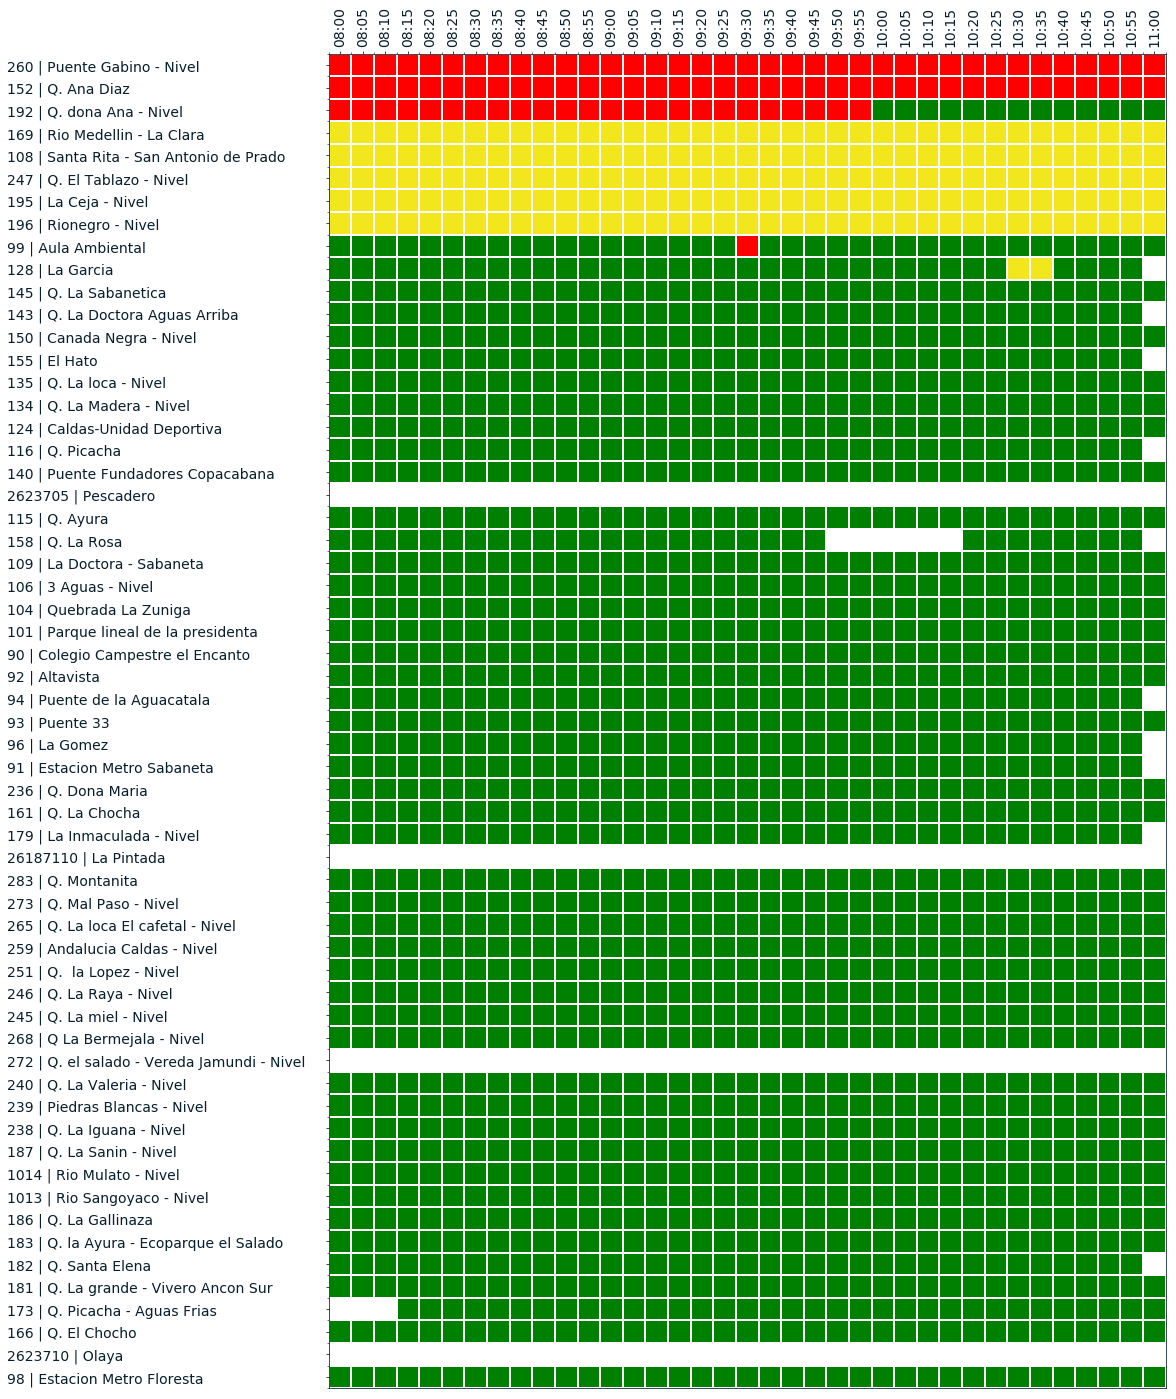

In [38]:
#PROCESS
self = cpr.Nivel(codigo = 99,user='sample_user',passwd='s@mple_p@ss',SimuBasin=False)
df = data_base_query() #dataframe level
risk_df = convert_to_risk(df.copy()) 
in_risk = risk_report(risk_df) # risk dataframe

#ejecuta plots en paralelo   
if in_risk.size > 0:
    if __name__ == '__main__':
        p = multiprocessing.Process(target=plots_vs_History, name="r")
        p.start()
        time.sleep(100) # wait near 5 minutes to kill process
        p.terminate()
        p.join()

In [ ]:
# process order according to risk
if __name__ == '__main__':
    p = multiprocessing.Process(target=reporte_lluvia, name="r")
    p.start()
    time.sleep(100) # wait near 5 minutes to kill process
    p.terminate()
    p.join()

try:
    df[risk_df.sum(axis=1).sort_values(ascending=False).index] # o
except:
    print 'ordering didnt work'
    pass
#TO KILL PROCESS AFTER CERTAIN PERIOD OF TIME
if __name__ == '__main__':
    p = multiprocessing.Process(target=process_multiple_plots_looping, name="")
    p.start()
    time.sleep(290) # wait near 5 minutes to kill process
    p.terminate()
    p.join()

    
df.to_csv('/media/nicolas/maso/Mario/tres_horas.csv')

#TO KILL PROCESS AFTER CERTAIN PERIOD OF TIME

import cprv1.cprv1 as cpr
import datetime
import os
import matplotlib.pyplot as plt

try:
    self = cpr.Nivel(codigo = 302,user='sample_user',passwd='s@mple_p@ss',SimuBasin=False)
    end = datetime.datetime.now()
    start = end - datetime.timedelta(hours=2)

    fig = plt.figure(figsize=(20,18))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)


    s = (self.fecha_hora_format_data('ni',start,end)-2095)/100.
    s.abs().plot(fontsize=20,ax=ax1)
    ax1.set_ylabel('Nivel (m)',fontsize=20)
    ax1.set_xlabel('hora',fontsize=20)

    start = end - datetime.timedelta(hours=12)
    s = (self.fecha_hora_format_data('ni',start,end)-2095)/100.
    s.abs().plot(fontsize=20,ax=ax2)
    ax2.set_ylabel('Nivel (m)',fontsize=20)
    ax2.set_xlabel('hora',fontsize=20)
    ax1.set_title('dos horas',fontsize=20)
    ax2.set_title('doce horas',fontsize=20)

    filepath ='/media/nicolas/Home/Jupyter/MarioLoco/reportes/hidroituango.png'
    #plt.suptitle('ver reporte de lluvia en esta misma carpeta')
    plt.savefig(filepath,bbox_inches='tight')
    os.system('scp %s mcano@siata.gov.co:/var/www/mario'%filepath)
except:
    print 'didnt work'
    pass